In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from astropy.io import fits,ascii

4
[-0.18647867 -0.08330028 -0.30183982 ... -0.17789251 -0.19661184
 -0.01989312]


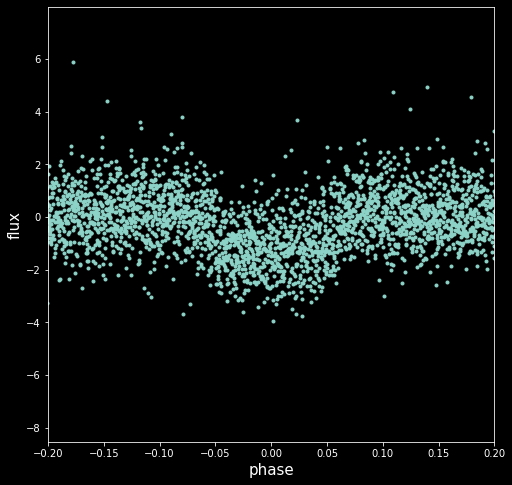

In [12]:
FILEPATH = 'E:\Masters_Project_Data\\alienworlds_fps\\'
FILEPATH2 = 'kplr001718189-20160128150956_dvt.fits'
FILEPATH_PL = 'kplr010797460-20160128150956_dvt.fits'
FILEPATH3 = 'nonpl_fps_red\\global\\008315220_7_g'
entry=os.listdir(FILEPATH)
hdu = fits.open(FILEPATH+FILEPATH_PL)
m=len(hdu)
print(m)


plt.style.use('dark_background')
#phase=hdu[1].data['PHASE']/hdu[1].header['TPERIOD']
time=hdu[m-1].data['TIME']
flux2=hdu[len(hdu)-1].data['RESIDUAL_LC']
flux2 = np.asarray([0 if np.isnan(el) else el for el in flux2])
flux2 = (flux2 - np.median(flux2)) / (np.median(flux2)-min(flux2))
print(flux2)
flux=hdu[1].data['LC_DETREND']
phase = hdu[1].data['PHASE']
flux=hdu[1].data['LC_WHITE']
#model = hdu[1].data['MODEL_WHITE']
#df=pd.read_csv(FILEPATH2,sep=" ")
#print(hdu[2].header)
#print(hdu[1].data['LC_DETREND'][0:10])
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(phase, flux,marker='.', ls='None')
#ax.plot(phase, model,marker='.', ls='None')

ax.set_xlabel('phase', size=15)
ax.set_ylabel('flux', size=15)
#ax.set_ylabel('flux', size=13)
#ax.set_title('Processed Data',size=20)
#ax[1].plot(phase, model-flux, marker='.',ls='None')
ax.set_xlim(-0.2,0.2)
#ax.set_xlim(-0.2,0.2)

plt.savefig('fprez_tmep.png')
plt.show()

In [36]:
#here we are searching for our residual feature thing... lets just try and see if its even possible
#i doubt tho... the limb darkening models are awful fancy here... lets see.

#phase folding: min to max

LOCAL_VIEW= 600
GLOBAL_VIEW=2000
def rebin(x,y,tr_dur,tr_pd):
    #change relevant stuff to days format from hours format
    tr_dur=tr_dur/24
    tempx=[]
    tempy=[]
    #remove Nan Values
    for i in range(0,len(y)):
        if(not np.isnan(y[i])):
            tempx.append(x[i])
            tempy.append(y[i])
    x=tempx
    y=tempy
    df = pd.DataFrame(list(zip(x, y)),columns =['phase', 'flux'])
    
    #create bins needed according to local and global view
    low=x[np.argmin(x)]
    high=x[np.argmax(x)]
    bins=np.linspace(low,high,GLOBAL_VIEW)
    bins_lc=np.linspace(-tr_dur,tr_dur,LOCAL_VIEW+1)

    #median out the contents of a group
    groups = df.groupby(np.digitize(df['phase'], bins))
    df_gl=groups.median()
    
    tot=pd.Series(np.arange(0,GLOBAL_VIEW))
    left=tot.index.difference(df_gl.index)
  
    #this is to fill up empty bins with values via interpolation.
    for el in left:
        if (el==0 or el==GLOBAL_VIEW): continue
        i=1
        while el-i in left or el+i in left:
            if (el-i==0 or el+i==GLOBAL_VIEW): break
            i=i+1
        if (el-i==0 or el+i==GLOBAL_VIEW): continue
        df_gl.loc[el]=[(df_gl.loc[el-i]['phase']+df_gl.loc[el+i]['phase'])/2,(df_gl.loc[el-i]['flux']+df_gl.loc[el+i]['flux'])/2]
    df_gl=df_gl.sort_index(axis=0)
    df_gl['phase']=df_gl['phase']/tr_pd

    #filter out the local view
    df_lc=df[(df["phase"] > -tr_dur) & (df["phase"] < tr_dur)]
    lc_groups = df_lc.groupby(np.digitize(df_lc['phase'], bins_lc))
    df_lc_f=lc_groups.median()

    tot=pd.Series(np.arange(0,LOCAL_VIEW))
    left=tot.index.difference(df_lc_f.index)

    for el in left:
        if (el==0 or el==LOCAL_VIEW): continue
        i=1
        while el-i in left or el+i in left:
            if (el-i==0 or el+i==LOCAL_VIEW): break
            i=i+1
        if (el-i==0 or el+i==LOCAL_VIEW): continue
        df_lc_f.loc[el]=[(df_lc_f.loc[el-i]['phase']+df_lc_f.loc[el+i]['phase'])/2,(df_lc_f.loc[el-i]['flux']+df_lc_f.loc[el+i]['flux'])/2]
    df_lc_f=df_lc_f.sort_index(axis=0)
    df_lc_f['phase']=df_lc_f['phase']/tr_dur

    return (df_lc_f,df_gl)


In [37]:
df_lc, df_gl = rebin(phase, flux, hdu[1].header['TDUR'], hdu[1].header['TPERIOD'])
df_lc_2, df_gl_2 = rebin(phase, model, hdu[1].header['TDUR'], hdu[1].header['TPERIOD'])


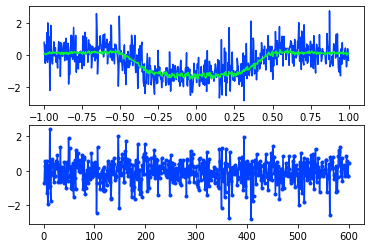

In [39]:
fig2,ax2 = plt.subplots(2,1)

ax2[0].plot(df_lc['phase'], df_lc['flux'])
ax2[0].plot(df_lc_2['phase'], df_lc_2['flux'])
ax2[1].plot(df_lc_2['flux'] - df_lc['flux'], marker='.')
#plt.xlim(-0.2,0.2)

In [41]:
df = [df_lc, df_lc_2, df_gl, df_gl_2]
df_final = pd.concat(df, axis=1)

df_final.to_csv("test.csv", index=False)

In [42]:
df = pd.read_csv('test.csv')
print(df)

         phase      flux   phase.1    flux.1   phase.2    flux.2   phase.3  \
0    -0.999184  0.796177 -0.999059  0.069695 -0.249766  0.139037 -0.249754   
1    -0.994519 -0.157207 -0.995088  0.116830 -0.249235 -0.208830 -0.249244   
2    -0.991905 -0.503773 -0.991951  0.081946 -0.248703 -0.186694 -0.248705   
3    -0.987042  0.639888 -0.987042  0.100014 -0.248288 -0.045552 -0.248268   
4    -0.984412 -0.310447 -0.984412  0.042618 -0.247821  0.080351 -0.247808   
...        ...       ...       ...       ...       ...       ...       ...   
1995       NaN       NaN       NaN       NaN  0.748263 -0.041538  0.748216   
1996       NaN       NaN       NaN       NaN  0.748719  0.425032  0.748719   
1997       NaN       NaN       NaN       NaN  0.749242 -0.099208  0.749248   
1998       NaN       NaN       NaN       NaN  0.749760 -0.188081  0.749753   
1999       NaN       NaN       NaN       NaN  0.750000  0.196809  0.750000   

        flux.3  
0    -0.003399  
1    -0.002868  
2    -0.0028

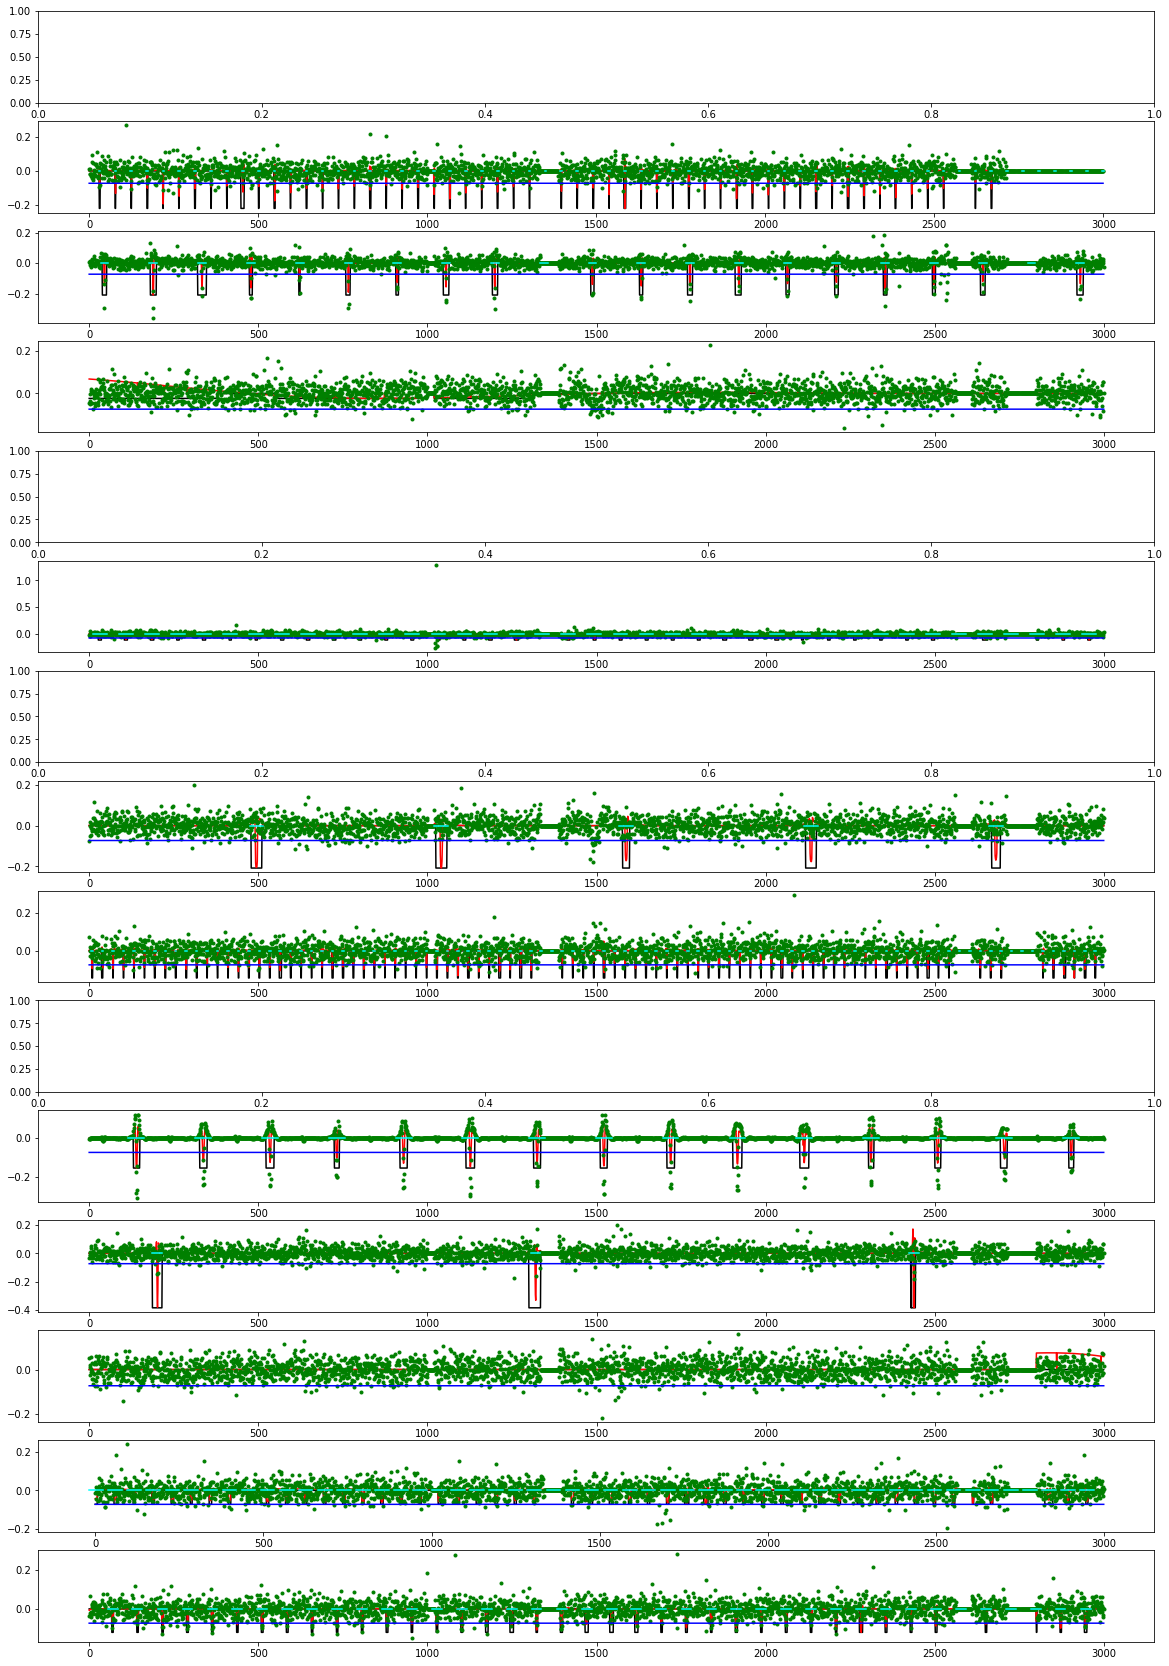

In [40]:
#this whole block is for checking the mask defining procedure, which isnt so black and white as it looks like
FILEPATH = 'E:\Masters_Project_Data\\alienworlds_fps\\'
entry=os.listdir(FILEPATH)
fig, ax = plt.subplots(15,1,figsize=(20,30))
for i in range(0,15):
    hdu = fits.open(FILEPATH+entry[i+1500])
    m=len(hdu)
    #if(m>3): continue
    time=hdu[m-1].data['TIME']
    for k in range(1,2):
        tdur=hdu[k].header['TDUR']
        npix=int(tdur*60/29)
        phase=hdu[k].data['PHASE'][3500:6500]
        model=hdu[k].data['MODEL_WHITE'][3500:6500]
        data=hdu[k].data['LC_WHITE'][3500:6500]
        temp=np.array([[phase[i],model[i],data[i]] if(not np.isnan(model[i]) and not np.isnan(data[i])) 
            else [phase[i],0,0] for i in range(0,len(phase))])
        phase=temp[:,0]
        clean=temp[:,1]
        data=temp[:,2]
        
        norm = np.linalg.norm(clean)
        d_norm = np.linalg.norm(data)
        if(norm==0 or d_norm==0): continue
        data = data*2/d_norm
        clean = clean/norm

        thres=np.median(clean)-0.5*np.std(clean)
        thres2=np.median(clean)+0.7*np.std(clean)
        thres3=np.median(data)-2*np.std(data)
        #cleanbin=[-1 if np.abs(x)>0.005 else 0 for x in grad]
        cleanbin=[-1 if (x<thres or x>thres2) else 0 for x in clean]
        for m in range(4,len(cleanbin)-4):
            if(cleanbin[m]==0):
                if(cleanbin[m-1]==-1 and cleanbin[m+1]==-1): 
                    cleanbin[m]=-1
                elif(cleanbin[m-2]==-1 and cleanbin[m+2]==-1): 
                    cleanbin[m]=-1
                elif(cleanbin[m-3]==-1 and cleanbin[m+3]==-1): 
                    cleanbin[m]=-1
                elif(cleanbin[m-4]==-1 and cleanbin[m+4]==-1): 
                    cleanbin[m]=-1
        for m in range(4,len(cleanbin)-4):
            if(cleanbin[m]==0):
                if(cleanbin[m-1]==-1 and cleanbin[m+1]==-1): 
                    cleanbin[m]=-1
                elif(cleanbin[m-2]==-1 and cleanbin[m+2]==-1): 
                    cleanbin[m]=-1
                elif(cleanbin[m-3]==-1 and cleanbin[m+3]==-1): 
                    cleanbin[m]=-1
                elif(cleanbin[m-4]==-1 and cleanbin[m+4]==-1): 
                    cleanbin[m]=-1

        cleanbin=np.array(cleanbin)
        ax[i].plot(-cleanbin*clean[np.argmin(clean)],color='black')
        #ax[i].plot(thres*np.ones(len(clean)),color='blue')
        
        ax[i].plot(clean,color='red')
        ax[i].plot(data,marker='.',ls='None',color='green')
        [ax[i].plot(np.arange(x-3*npix,x+3*npix),np.zeros(len(np.arange(x-3*npix,x+3*npix))),color='aqua') for x in range(1,len(phase))
            if(phase[x]*phase[x-1]<0 and np.abs(phase[x]*phase[x-1])<0.001) ]
        ax[i].plot(thres3*np.ones(len(clean)),color='blue')
        

        #ax[i].plot(grad,color='black',marker='.', ls='None')
        
plt.show()

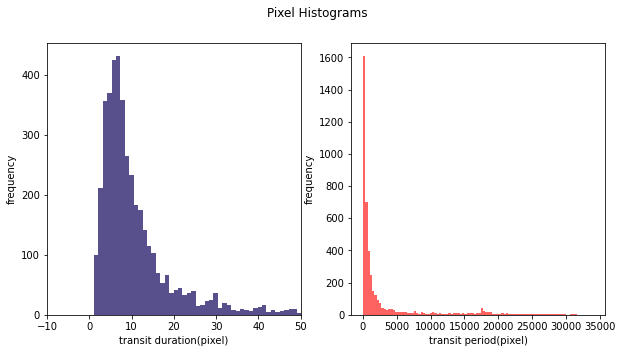

576


In [7]:
#this is making some more diagnostic plots
data=pd.read_csv("../../Catalogs/data_summary.dat", sep = " ")
tdur=data['transit_duration']
tperiod=data['transit_period']
fig,ax = plt.subplots(1,2,figsize=(10,5))
plt.suptitle('Pixel Histograms')
ax[0].hist(tdur*2,bins=300, color='#58508d')
ax[0].set_xlim(-10,50)
ax[0].set_xlabel('transit duration(pixel)')
ax[0].set_ylabel('frequency')
ax[1].hist(tperiod*24*2,bins=100,color='#ff6361')
ax[1].set_xlabel('transit period(pixel)')
ax[1].set_ylabel('frequency')
#plt.savefig('pixel_hist.png')
plt.show()

print((tdur*2<4).sum())



In [7]:
#testing out TCE lengths

tce_length=[]

FILEPATH_DATA="E:\Masters_Project_Data\\alienworlds_data\\"
FILEPATH_FPS=r"E:\Masters_Project_Data\\alienworlds_fps\\"
#pl_entry=os.listdir(FILEPATH_DATA)
fps_entry=os.listdir(FILEPATH_FPS)
'''for el in pl_entry:
    hdu = fits.open(FILEPATH_DATA+el)
    #tce_length.append(len(hdu))
    for i in range(1,len(hdu)-1):
        try: 
            if(hdu[i].header['NTRANS']>2): tce_length.append(hdu[i].header['NTRANS'])
        except: continue'''
for el in fps_entry:
    hdu = fits.open(FILEPATH_FPS+el)
    #tce_length.append(len(hdu))
    for i in range(1,len(hdu)-1):
        try: 
            if(hdu[i].header['NTRANS']>2): tce_length.append(hdu[i].header['NTRANS'])
        except: continue

plt.hist(np.array(tce_length),bins=200,color='#bc5090')
plt.title('Number of systems in Target')
plt.xlabel('Number of transits in observation')
#print((np.array(tce_length)<4).sum())
plt.savefig('planetary_system_ntrans.png')
plt.xlim(-10,510)
plt.show
    

    Header size is not multiple of 2880: 6711176
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 5454456
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


KeyboardInterrupt: 

In [2]:
#get some basic info about existing files in ascii table, plus their labels... so data processing becomes easier
FILEPATH="F:\Masters_Project_Data\\alienworlds_fps\\"
entries=os.listdir(FILEPATH)
tdur=[]
tdepth=[]
tlabel=[]
tperiod=[]
tname=[]
tdiff=[]
length=[]
x=0
for el in entries:
    hdu = fits.open(FILEPATH+el.name)
    n=len(hdu)
    x=x+1
    #if(x==10): break
    for i in range(1,n-1):
        if(hdu[i].header['TDUR']==None): tdur.append(0.0)
        else: tdur.append(hdu[i].header['TDUR'])
        if(hdu[i].header['TDEPTH']==None): tdur.append(0.0)
        else: tdepth.append(hdu[i].header['TDEPTH'])
        if(hdu[i].header['TPERIOD']==None): tdur.append(0.0)
        else: tperiod.append(hdu[i].header['TPERIOD'])

        tlabel.append(1)
        tdiff.append(hdu[i].data['TIME'][-1]-hdu[i].data['TIME'][1])
        length.append(len(hdu[i].data['LC_DETREND']))
        tname.append(el.name[4:13]+'_'+str(i))

FILEPATH="F:\Masters_Project_Data\\alienworlds_data\\"
entries=os.scandir(FILEPATH)
for el in entries:
    hdu = fits.open(FILEPATH+el.name)
    n=len(hdu)
    x=x+1
    #if(x==10): break
    for i in range(1,n-1):
        if(hdu[i].header['TDUR']==None): tdur.append(0.0)
        else: tdur.append(hdu[i].header['TDUR'])
        if(hdu[i].header['TDEPTH']==None): tdur.append(0.0)
        else: tdepth.append(hdu[i].header['TDEPTH'])
        if(hdu[i].header['TPERIOD']==None): tdur.append(0.0)
        else: tperiod.append(hdu[i].header['TPERIOD'])
        tlabel.append(0)
        tdiff.append(hdu[i].data['TIME'][-1]-hdu[i].data['TIME'][1])
        length.append(len(hdu[i].data['LC_DETREND']))
        tname.append(el.name[4:13]+'_'+str(i))

df=pd.DataFrame(list(zip(tname,tlabel,tdur,tdepth,tperiod,tdiff,length)),columns =['ID', 'label','transit_duration','transit_depth','transit_period','obs_dur','data_length'])
df.to_csv('data_summary_2.dat',sep=' ',index=False)    

    Header size is not multiple of 2880: 6711176
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 5454456
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 30699888
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


In [18]:
#get some basic info about existing files in ascii table, plus their labels... so data processing becomes easier
FILEPATH="F:\Masters_Project_Data\\alienworlds_fps\\"
entries=os.scandir(FILEPATH)
tdur=[]
tdepth=[]
tlabel=[]
tperiod=[]
tname=[]
tdiff=[]
length=[]
ntrans=[]
x=0
for el in entries:
    hdu = fits.open(FILEPATH+el.name)
    n=len(hdu)
    x=x+1
    #if(x==10): break
    for i in range(1,n-1):
        if(hdu[i].header['TDUR']==None): tdur.append(0.0)
        else: tdur.append(hdu[i].header['TDUR'])
        if(hdu[i].header['TDEPTH']==None): tdur.append(0.0)
        else: tdepth.append(hdu[i].header['TDEPTH'])
        if(hdu[i].header['TPERIOD']==None): tdur.append(0.0)
        else: tperiod.append(hdu[i].header['TPERIOD'])
        ntrans.append(hdu[i].header['NTRANS'])

        tlabel.append(1)
        tdiff.append(hdu[i].data['TIME'][-1]-hdu[i].data['TIME'][1])
        length.append(len(hdu[i].data['LC_DETREND']))
        tname.append(el.name[4:13]+'_'+str(i))

FILEPATH="F:\Masters_Project_Data\\alienworlds_data\\"
entries=os.scandir(FILEPATH)
for el in entries:
    hdu = fits.open(FILEPATH+el.name)
    n=len(hdu)
    x=x+1
    #if(x==10): break
    for i in range(1,n-1):
        if(hdu[i].header['TDUR']==None): tdur.append(0.0)
        else: tdur.append(hdu[i].header['TDUR'])
        if(hdu[i].header['TDEPTH']==None): tdur.append(0.0)
        else: tdepth.append(hdu[i].header['TDEPTH'])
        if(hdu[i].header['TPERIOD']==None): tdur.append(0.0)
        else: tperiod.append(hdu[i].header['TPERIOD'])
        ntrans.append(hdu[i].header['NTRANS'])
        tlabel.append(0)
        tdiff.append(hdu[i].data['TIME'][-1]-hdu[i].data['TIME'][1])
        length.append(len(hdu[i].data['LC_DETREND']))
        tname.append(el.name[4:13]+'_'+str(i))

print(ntrans[np.argmin(ntrans)],ntrans[np.argmax(ntrans)])
print(tperiod[np.argmin(tperiod)],tperiod[np.argmax(tperiod)])
df=pd.DataFrame(list(zip(tname,tlabel,tdur,tdepth,tperiod,tdiff,ntrans,length)),columns =['ID', 'label','transit_duration','transit_depth','transit_period','obs_dur','ntrans','data_length'])
df.to_csv('data_summary_2.dat',sep=' ',index=False)    

    Header size is not multiple of 2880: 6711176
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 5454456
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 30699888
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


0 0


In [2]:
#count stuff in autovetter
av_entry = ascii.read('autovetter_label.tab')
lab = av_entry['av_training_set']
print(np.asarray(lab=='PC').sum())
print(np.asarray(lab=='FPS').sum())
print(np.asarray(lab=='CANDIDATE').sum())
#print(np.asarray(lab=='NTP').sum())
print(len(lab))

2362
4840
2362
9564


In [5]:
tce_en = ascii.read('ex_tce_sum.tab')
print(len(tce_en['kepid']))
koi_en = ascii.read('ex_koi_id.tab')
print(len(koi_en['kepid']))

34032
9564


In [4]:
#diagnosing data lengths...
data=pd.read_csv("data_summary.dat", sep = " ")
length=[data['data_length'][i]  for i in range(0,len(data)) if data['label'][i]==0]
print(length[np.argmax(length)])
print(length[np.argmin(length)])

71427
71427


In [5]:
#diagnosing transit information...
tdur=[data['transit_duration'][i]  for i in range(0,len(data)) if data['label'][i]==0]
tperiod=[data['transit_period'][i]  for i in range(0,len(data)) if data['label'][i]==0]
tname=[data['ID'][i]  for i in range(0,len(data)) if data['label'][i]==0]
print(tdur[np.argmax(tdur)], tname[np.argmax(tdur)])
print(tdur[np.argmin(tdur)], tname[np.argmin(tdur)])
print(tperiod[np.argmax(tperiod)], tname[np.argmax(tperiod)])
print(tperiod[np.argmin(tperiod)], tname[np.argmin(tperiod)])

68.63294152078244 008494410_3
0.5644104044333844 009718066_3
709.6511639514649 010599206_2
0.5185186537560659 009642292_2


In [2]:
#looking for corrupt data... will redownload.
FILEPATH="F:\Masters Project Data\\alienworlds_data\\"
entries=os.scandir(FILEPATH)
x=0
for el in entries:
    hdu = fits.open(FILEPATH+el.name)
    n=len(hdu)
    x=x+1
    if(hdu.verify('exception')!=None): print(el.name)
        
    

    Header size is not multiple of 2880: 6711176
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 5454456
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 30699888
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


In [3]:
#temporary
FILEPATH="data_red/global/"
entries=os.scandir(FILEPATH)
for el in entries:
    df = pd.read_csv(FILEPATH+el.name)
    print(len(df),el.name)
#01112938 or 01112958 

1000 57450_1_g
1000 32789_1_g
1000 32789_2_g
1000 18189_1_g
1000 18189_2_g
1000 18189_3_g
1000 24719_1_g
1000 24719_2_g
1000 25016_1_g
1000 65042_1_g
1000 71056_1_g
1000 71056_2_g
1000 73513_1_g
1000 95519_1_g
1000 95519_2_g
1000 96180_1_g
1000 96180_2_g
1000 42522_1_g
1000 65002_1_g
1000 65002_2_g
1000 02548_1_g
1000 02548_2_g
1000 04320_1_g
1000 07415_1_g
1000 07415_2_g
1000 38264_1_g
1000 38264_2_g
1000 39243_1_g
1000 41495_1_g
1000 42448_1_g
1000 56650_1_g
1000 57816_1_g
1000 71238_1_g
1000 81316_1_g
1000 81316_2_g
1000 81554_1_g
1000 84163_1_g
1000 92377_1_g
1000 92377_2_g
1000 93736_1_g
1000 13049_1_g
1000 15135_1_g
1000 15135_2_g
1000 15135_3_g
913 15135_4_g
1000 16801_1_g
1000 16801_2_g
1000 16853_1_g
1000 16853_2_g
1000 21030_1_g
1000 31055_1_g
1000 37111_1_g
1000 37111_2_g
1000 49805_1_g
1000 53093_1_g
1000 54698_1_g
1000 54698_2_g
1000 54914_1_g
1000 54914_2_g
1000 75770_1_g
1000 75770_2_g
1000 85767_1_g
1000 87027_1_g
1000 89404_1_g
1000 89404_2_g
1000 90873_1_g
1000 95392_

KeyboardInterrupt: 

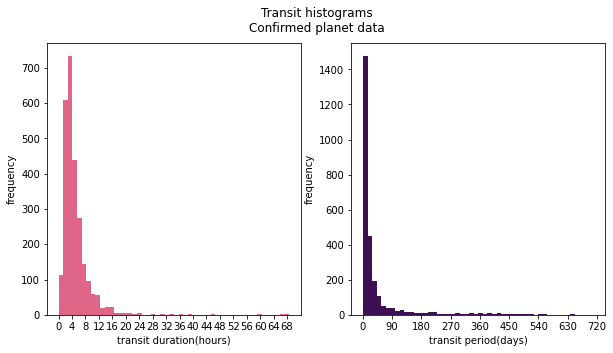

In [23]:
data=pd.read_csv("data_summary_2.dat", sep = " ")
dur=[data['transit_duration'][i]  for i in range(0,len(data)) if data['label'][i]==0]
period=[data['transit_period'][i]  for i in range(0,len(data)) if data['label'][i]==0]
print(len(dur))

fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].hist(dur, bins=50, color='#DF6589FF')
ax[0].set_xlabel('transit duration(hours)')
ax[0].set_ylabel('frequency')
ax[0].set_xticks(range(0,70,int(70*3/50)))
ax[1].hist(period, bins=50, color='#3C1053FF')
ax[1].set_xlabel('transit period(days)')
ax[1].set_ylabel('frequency')
ax[1].set_xticks(range(0,721,90))
plt.suptitle('Transit histograms\nConfirmed planet data')
plt.savefig('ConfirmedPlHistogram.png')
plt.show()
